In [1]:
#plan
#get one timeslice of LM data
#get the corresponding normalization sinogram
#calculate the histogram bins
#calculate image bins
#add histogram points weighted by the normalization component
#time it

In [2]:
import numpy as np

#visuals
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

#Interactive
from ipywidgets.widgets import * 
import ipywidgets as widgets

#take time, for checking if vectorization/program is useful
import time

#Hugo code
import Utility
import Datasets

In [3]:
time_str = "elapsed time [s]"
def time_function(func):
    time_a = time.time()
    func()
    time_b = time.time()
    print(time_str, time_b-time_a)

In [4]:
def f():
    K = np.power(10, 5)
    for k in range(K):
        a = 0
    return 3

time_function(f)

elapsed time [s] 0.001994609832763672


In [5]:
LM_dataset, LM_paths = Datasets.KEX_listmode_files()
ref = 0
time_a = time.time()
for k,p in enumerate(LM_paths):
    print("LM path end:",p.split('/')[-1])
    elements = len(LM_dataset[k])
    print("list length:", elements)
    if elements == ref:
        print("strange list length")
    ref = elements
    time_b = time.time()
    print("elapsed time", time_b-time_a)
print("done")

LM path end: CylinderPET-LM-00.l
list length: 16866873
elapsed time 0.000995635986328125
LM path end: CylinderPET-LM-01.l
list length: 16887694
elapsed time 0.000995635986328125
LM path end: KanylPET-LM-00.l
list length: 37971248
elapsed time 0.000995635986328125
LM path end: KanylPET-LM-01.l
list length: 37394799
elapsed time 0.0019927024841308594
done


In [6]:
norm3d_list, norm_paths = Datasets.KEX_intermediate_files(only_norm=True)
test_shape = (621,168,400)
error_count = 0
for k,p in enumerate(norm_paths):
    print("norm path end:",p.split('/')[-2:])
    print("norm shape", norm3d_list[k].shape)
    for d in range(3):
        if norm3d_list[k].shape[d] != test_shape[d]:
            error_count +=1

if error_count > 0:
    print("unexpected normalization sinogram shape")
print("done")

norm path end: ['CylinderPET-00', 'norm3d_00.a']
norm shape (621, 168, 400)
norm path end: ['CylinderPET-01', 'norm3d_00.a']
norm shape (621, 168, 400)
norm path end: ['KanylPET-00', 'norm3d_00.a']
norm shape (621, 168, 400)
norm path end: ['KanylPET-01', 'norm3d_00.a']
norm shape (621, 168, 400)
done


In [7]:
def normalized_center_of_mass(image_bins, histogram_bins, normalization_matrix):
    return np.sum(image_bins*normalization, axis=1) / np.sum(normalization)

In [8]:
def get_image_bins(listmode_data, offsetTOF=True, return_intermediates_bool=True):
    """ get_image_bin: extracts the image bins in FOV of prompts of events, 
    also (by default) returns intermediate results.
    input: listmode_data, offsetTOF=True, return_intermediates_bool=True
    return FOV_image_bins, FOV_LOR_bins, 
    event_TOF_LOR_bins,b_events, b_prompts, b_image_FOV"""
    b_events = Utility.bEvents(listmode_data)
    events = listmode_data[b_events]
    b_prompts = Utility.bPrompts(events)
    prompts_ba = events[b_prompts]
    event_TOF_LOR_bins = Utility.binAddressToProjectionSpace(events)
    image_bins = Utility.imageBinFromHistogramBin(histogramBin=event_TOF_LOR_bins[:, b_prompts], 
                                                  offsetTOF=offsetTOF, 
                                                  delays=False,
                                                 verbose=False)
    b_image_FOV = Utility.bValidBin(image_bins, Utility.IMAGE_SHAPE)
    FOV_image_bins = image_bins[:,b_image_FOV]
   
    
    if return_intermediates_bool:
        #useful but not strictly necessary
        FOV_LOR_bins = event_TOF_LOR_bins[1:,b_prompts][:,b_image_FOV]
        return FOV_image_bins, FOV_LOR_bins, event_TOF_LOR_bins,b_events, b_prompts, b_image_FOV
    else:
        return FOV_image_bins

In [9]:
#get the bins from LM data
print(get_image_bins.__doc__)
verbose = False

#store the entire list
event_TOF_LOR_bins_list = []
FOV_image_bins_list = []
FOV_LOR_bins_list = []

#store these for time slicing later on
event_boolarray_list = []
prompt_boolarray_list = []
image_FOV_boolarray_list = []

#get image bins
for k,LM in enumerate(LM_dataset):
    
    def func():
        FOV_img_bin, FOV_LOR_bin, TOF_LOR_bin, event_b, prompt_b, image_FOV_b = get_image_bins(LM, return_intermediates_bool=True)
        FOV_image_bins_list.append(FOV_img_bin)
        FOV_LOR_bins_list.append(FOV_LOR_bin)
        event_TOF_LOR_bins_list.append(TOF_LOR_bin)
        
        event_boolarray_list.append(event_b)
        prompt_boolarray_list.append(prompt_b)
        image_FOV_boolarray_list.append(image_FOV_b)
        return 0
    
    time_function(func)
print("done")

 get_image_bin: extracts the image bins in FOV of prompts of events, 
    also (by default) returns intermediate results.
    input: listmode_data, offsetTOF=True, return_intermediates_bool=True
    return FOV_image_bins, FOV_LOR_bins, 
    event_TOF_LOR_bins,b_events, b_prompts, b_image_FOV
--- Shapes ---
event_point_mm (3, 14688186)
origin_array (3,)
---uniques---
t_point_mm [-573.82150164 -573.72117521 -573.72117521 ...  573.72117521  573.72117521
  573.82150164]
tof_offset [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
elapsed time [s] 10.992736577987671
--- Shapes ---
event_point_mm (3, 14702789)
origin_array (3,)
---uniques---
t_point_mm [-573.82150164 -573.72117521 -573.72117521 ...  573.72117521  573.72117521
  573.82150164]
tof_offset [-6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
elapsed time [s] 10.910638570785522
--- Shapes ---
event_point_mm (3, 36717977)
origin_array (3,)
---uniques---
t_point_mm [-573.82150164 -573.72117521 -573.72117521 ...  573.72117521  573.72117521
  573.8215016

In [10]:
def get_timslice_indices(listmode_data, 
                         event_in_LM_boolarray, 
                         prompt_in_event_boolarray, 
                         FOV_in_prompt_boolarray, 
                         timeTagsPerSlice):
    
    """ get_timeslice_indices: indices into: listmode data, event list, prompt list, and FOV prompt list
        input: listmode_data, event_in_LM_boolarray,prompt_in_event_boolarray, FOV_in_prompt_boolarray, timeTagsPerSlice
        return timeslice_in_LM, timeslice_in_event, timeslice_in_prompt, timeslice_in_FOV """
    
    if len(listmode_data)==0:
        #this case will return [],[],[]
        listmode_data = np.array([0])
    
    timetag_boolarray = Utility.bTimeTag(listmode_data)

    timetag_in_LM = np.nonzero(timetag_boolarray)[0]
    event_in_LM = np.nonzero(event_in_LM_boolarray)[0]
    prompt_in_event = np.nonzero(prompt_in_event_boolarray)[0]
    FOV_in_prompt = np.nonzero(FOV_in_prompt_boolarray)[0]
    
    #splits at offset start to end with scaled stepsize
    timeslice_in_LM = timetag_in_LM[timeTagsPerSlice: :timeTagsPerSlice]
    #find where the timeslice would fit in (despite time tags being removed)
    timeslice_in_event = np.searchsorted(event_in_LM, timeslice_in_LM, side='left')
    
    #timeslice_in_prompt is somewhat redundant, but calculating it is actually efficient
    timeslice_in_prompt = np.searchsorted(prompt_in_event, timeslice_in_event, side='left')
    timeslice_in_FOV = np.searchsorted(FOV_in_prompt, timeslice_in_prompt, side='left')
    return timeslice_in_LM, timeslice_in_event, timeslice_in_prompt, timeslice_in_FOV

In [11]:
#test
arr = np.array([])
a,b,c,d = get_timslice_indices(arr,arr,arr,arr,timeTagsPerSlice=1)
print(a)
print(b)
print(c)
print(d)

[]
[]
[]
[]


In [12]:
#get timeslice indices
timeTagsPerSlice=10000
timeslices_in_LM_list = []
timeslices_in_event_list = []
timeslices_in_prompt_list = []
timeslices_in_FOV_list = []

for k, LM in enumerate(LM_dataset):
    time_a = time.time()
    split_in_LM, split_in_event, split_in_prompt, split_in_FOV = get_timslice_indices(LM,
                                                                     event_in_LM_boolarray=event_boolarray_list[k],
                                                                    prompt_in_event_boolarray=prompt_boolarray_list[k],
                                                                    FOV_in_prompt_boolarray=image_FOV_boolarray_list[k],
                                                                    timeTagsPerSlice=timeTagsPerSlice)
    timeslices_in_LM_list.append(split_in_LM)
    timeslices_in_event_list.append(split_in_event)
    timeslices_in_prompt_list.append(split_in_prompt)
    timeslices_in_FOV_list.append(split_in_FOV)
    time_b = time.time()
    print(time_str, time_b-time_a)
print("done")

elapsed time [s] 0.49268150329589844
elapsed time [s] 0.47980523109436035
elapsed time [s] 1.0457653999328613
elapsed time [s] 1.0474379062652588
done


C:\Users\petct\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


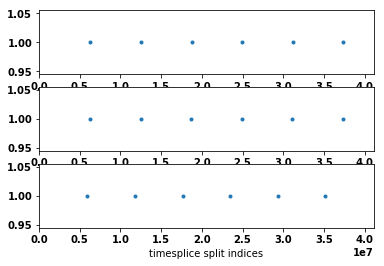

In [13]:
#check if reasonable, the timeslice indices should be spaced out about equally in time
timesplits = [split_in_LM, split_in_event, split_in_FOV]
for k,ts in enumerate(timesplits):
    plt.subplot(len(timesplits), 1, k+1)
    plt.plot(ts, np.ones_like(ts), '.')
    plt.xlabel("timesplice split indices")
    plt.xlim(0,timesplits[0][-1]*1.1)
    
plt.show()
    #print(ts)

In [14]:
def get_center_of_mass_trace(image_bins, 
                             split_at_indices,
                             sinogram_bins=None, 
                             norm_sinogram3d=None, verbose=False):
    """ get_center_of_mass_trace: splits image bins into timeslices and calculates the center of mass (mean). 
    If sinogram bins and normalization is provided, the center of mass is normalized. 
    Input: image_bins, split_at_indices,sinogram_bins=None, norm_sinogram3d=None, verbose=False
    return com_trace
    FOV_image_bins is assumed to be shaped (3,_), and the return is shaped (3,_)"""
    
    axis_number=1
    imagebin_slices = np.split(image_bins, split_at_indices, axis=axis_number)
    com_trace = np.zeros((3, len(imagebin_slices)))
    
    if sinogram_bins is None or norm_sinogram3d is None:
        for slice_number,image_bins in enumerate(imagebin_slices):
            com_trace[:,slice_number] = np.mean(image_bins, axis=axis_number)
    else:
        if verbose:
            print("FOV image bins shape", image_bins.shape)
            print("FOV sinogram bins shape", sinogram_bins.shape)
        sino_slices = np.split(sinogram_bins, split_at_indices, axis=axis_number)
        
        for slice_number, image_bins in enumerate(imagebin_slices):
            weights = norm_sinogram3d[tuple(sino_slices[slice_number])]
            if verbose:
                print("slice number", slice_number)
                print("weights shape", weights.shape)
                print("image_bins shape", image_bins.shape)
                print("product shape ", product.shape)
                print("com shape", com.shape)
            product = image_bins*weights
                
            com = np.sum(product,axis=axis_number) / np.sum(weights)
            
            com_trace[:, slice_number] = com 
        
    return com_trace

In [15]:
#now calculate the center of mass for each timeslice
#with and without normalization for comparison
time_a = time.time()
center_of_mass_trace_list = []
normalized_center_of_mass_trace_list = []
verbose=False
for data_number, FOV_image_bins in enumerate(FOV_image_bins_list):
    for normalize_b in [True, False]:
        if normalize_b:
            FOV_sinogram_bins = FOV_LOR_bins_list[data_number]
            normalisation_sinogram = norm3d_list[data_number]
            
        else:
            FOV_sinogram_bins=None
            normalisation_sinogram =None
            
        com_trace = get_center_of_mass_trace(image_bins=FOV_image_bins,
                                            split_at_indices=timeslices_in_FOV_list[data_number],
                                            sinogram_bins=FOV_sinogram_bins,
                                            norm_sinogram3d=normalisation_sinogram)
        if normalize_b:
            normalized_center_of_mass_trace_list.append(com_trace)
        else:
            center_of_mass_trace_list.append(com_trace)
    
    time_b = time.time()
    print(time_str, time_b-time_a)
print("done")

elapsed time [s] 1.4172120094299316
elapsed time [s] 2.8064792156219482
elapsed time [s] 6.070814609527588
elapsed time [s] 8.856498956680298
done


In [16]:
#get recon com for reference:
recons,recon_paths = Datasets.KEX_reconstructions()
recon_com = []
time_a = time.time()
for r in recons:
    recon_com.append(Utility.CenterOfMassMultiplication(r, convert_to_datatype=np.int64))
time_b = time.time()
print(time_str, time_b-time_a)
print("done")

elapsed time [s] 0.38881850242614746
done


In [17]:
def get_histo_image(image_bins, normalization_sinogram3d=None, sinogram_bins=None,histo_image=None):
    """get_histo_image: histograms image bins list. 
    Input: image_bins, normalization_sinogram3d=None, sinogram_bins=None,histo_image=None
    return: histo_image """
    
    if normalization_sinogram3d is None:
        normalization_sinogram3d = np.array([1])
        sinogram_bins = np.array([0])
    if histo_image is None:
        histo_image = np.zeros(Utility.IMAGE_SHAPE)
    np.add.at(histo_image, tuple(image_bins), normalization_sinogram3d[tuple(sinogram_bins)])
    return histo_image

In [18]:
#mini test
image_bins = np.array([1,2,3])
histo_image=get_histo_image(image_bins,normalization_sinogram3d=None, sinogram_bins=None)
com = Utility.CenterOfMassMultiplication(histo_image)
if np.sum(image_bins -com) == 0:
    print("test passed")

test passed


In [19]:
# get histo images
norm_histo_images = []
histo_images = []
norm_histoimage_com = []
histoimage_com = []

verbose = False
time_a = time.time()
slice_number = 0
for data_number, image_bins in enumerate(FOV_image_bins_list):
    axis_number = 1
    split_image_bins = np.split(image_bins, timeslices_in_FOV_list[data_number], axis=axis_number)
    split_LOR_bins = np.split(FOV_LOR_bins_list[data_number], timeslices_in_FOV_list[data_number], axis=axis_number)
    
    norm_h_image=get_histo_image(split_image_bins[slice_number], norm3d_list[data_number],split_LOR_bins[slice_number])
    h_image = get_histo_image(image_bins)
    if verbose:
        z = 50
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(h_image[z])
        plt.title("z=" + str(z))
        plt.subplot(1,2,2)
        plt.imshow(norm_h_image[z])
        plt.title("normalized")
        plt.show()
    norm_histo_images.append(norm_h_image)
    histo_images.append(h_image)
    histoimage_com.append(center_of_mass_trace_list[data_number][:,slice_number])
    norm_histoimage_com.append(normalized_center_of_mass_trace_list[data_number][:,slice_number])
    
    time_b = time.time()
    print(time_str, time_b-time_a)
    
print("done")

elapsed time [s] 2.620588541030884
elapsed time [s] 5.317980051040649
elapsed time [s] 10.398770093917847
elapsed time [s] 15.007447957992554
done


In [20]:
#plot normalized
print("normalized histo images", timeTagsPerSlice , " ms")

z_slide = widgets.IntSlider(value=47, min=0, max=109-1)
verbose = False
if verbose:
    print("histo. image shape", histogram_image[0].shape)
    print("recon_com shape", recon_COM[0].shape)
    print("recon_COM [0]=",recon_COM[0])
    print("recon_COM [0] datatype", recon_COM[0].dtype)

def f(z):
    number_of_histograms = len(norm_histo_images)
    scale = 14
    plt.figure(figsize=(scale, scale))
    for data_number,histo in enumerate(norm_histo_images):
        plt.subplot(2,number_of_histograms/2,data_number+1)
        plt.imshow(histo[z])
        plt.colorbar()
        
        plt.xlabel(Utility.IMAGE_DIMENSION_TITLES[2])
        plt.ylabel(Utility.IMAGE_DIMENSION_TITLES[1])
        
        filename = "file " + LM_paths[data_number].split('/')[-1] 
        title_str = filename
        if True:
            recon_com_str = "red dot at recon. center of mass" 
            recon_com_str += "\n[z y x] =" +str(np.array(recon_com[data_number], dtype=int))
            histo_com_str = "white dot at histo. center of mass" 
            histo_com_str += "\n[z y x] =" +str(np.array(norm_histoimage_com[data_number], dtype=int))
            title_str = filename + "\n" + recon_com_str + "\n" + histo_com_str
            
            #add axes for orientation
            alpha = 0.2
            plt.axvline(x=[100],color='red', alpha=alpha)
            plt.axhline(y=[100],color='red',alpha=alpha)
            #add com points
            plt.scatter(recon_com[data_number][2], recon_com[data_number][1],color='r', marker='.')
            plt.scatter(norm_histoimage_com[data_number][2], norm_histoimage_com[data_number][1],color='w', marker='.')
            
        plt.title(title_str)
    
    plt.suptitle("z=" +str(z))

    plt.show()
    return z

interact(f,z=z_slide)    ;

normalized histo images 10000  ms


interactive(children=(IntSlider(value=47, description='z', max=108), Output()), _dom_classes=('widget-interact…

In [21]:
#plot normalized
#sum along an axis
print("normalized histo images", timeTagsPerSlice , " ms")

axis_sum_slide = widgets.IntSlider(value=0, min=0, max=2)
verbose = False
if verbose:
    print("histo. image shape", histogram_image[0].shape)
    print("recon_com shape", recon_COM[0].shape)
    print("recon_COM [0]=",recon_COM[0])
    print("recon_COM [0] datatype", recon_COM[0].dtype)

def f(axis_number):
    number_of_histograms = len(norm_histo_images)
    scale = 14
    plt.figure(figsize=(scale, scale))
    for data_number,histo in enumerate(norm_histo_images):
        plt.subplot(2,number_of_histograms/2,data_number+1)
        plt.imshow(np.sum(histo,axis=axis_number))
        plt.colorbar()
        dimension = []
        for dim in range(3):
            if dim != axis_number:
                dimension.append(dim)
                
                   
        plt.xlabel(Utility.IMAGE_DIMENSION_TITLES[dimension[1]])
        plt.ylabel(Utility.IMAGE_DIMENSION_TITLES[dimension[0]])
        
        filename = "file " + LM_paths[data_number].split('/')[-1] 
        title_str = filename
        if True:
            recon_com_str = "red dot at recon. center of mass" 
            recon_com_str += "\n[z y x] =" +str(np.array(recon_com[data_number], dtype=int))
            histo_com_str = "white dot at histo. center of mass" 
            histo_com_str += "\n[z y x] =" +str(np.array(norm_histoimage_com[data_number], dtype=int))
            title_str = filename + "\n" + recon_com_str + "\n" + histo_com_str
            
            #add axes for orientation
            alpha = 0.2
            plt.axvline(x=[100],color='red', alpha=alpha)
            plt.axhline(y=[100],color='red',alpha=alpha)
            #add com points
            plt.scatter(recon_com[data_number][dimension[1]], recon_com[data_number][dimension[0]],color='r', marker='.')
            plt.scatter(norm_histoimage_com[data_number][dimension[1]], norm_histoimage_com[data_number][dimension[0]],color='w', marker='.')
            
        plt.title(title_str)

    plt.show()
    return 0

interact(f,axis_number=axis_sum_slide)    ;

normalized histo images 10000  ms


interactive(children=(IntSlider(value=0, description='axis_number', max=2), Output()), _dom_classes=('widget-i…

In [22]:
#plot the COM
def plot_com(com_traces, 
             comparison_com_traces=None, 
             com_references=recon_com, 
             gates_per_phantom=[2,2],
             legends=["histo image", "recon."], 
             data_paths=LM_paths):
    
    """ plot_com: plots the center of mass traces in z y x along with the reference (constant lines)
    gates are plotted together, with adjacent first-last timeslices.
    input: com_traces,
    comparison_com_traces=None, 
    com_references=recon_com,
    gates_per_phantom=[2,2],
    legends=["histo image", "recon."],
    data_paths=LM_paths"""
    
    xlabel = "time slice number\n" + str(timeTagsPerSlice) + " ms per slice"
    reset_ylim = [False,True]
    columns = len(reset_ylim)

    gate_b=0

    for phantom_number in range(len(gates_per_phantom)):
        phantom_trace = []
        gate_a = gate_b
        gate_b += gates_per_phantom[phantom_number]

        plt.figure(figsize=(20,5))
        for dim_number,dim_str in enumerate(Utility.IMAGE_DIMENSION_TITLES):
            for k,redo_y in enumerate(reset_ylim):
                plot_legends = []
                hline_legends = []
                timeslice_b = 0
                plt.subplot(3,columns,columns*dim_number+1+k)
                if dim_number== 0:
                    plt.title("phantom " + data_paths[gate_a].split('/')[-1].split('-')[0])
                if redo_y:
                        plt.ylim(0,Utility.IMAGE_SHAPE[dim_number])
                for data_number in range(gate_a, gate_b):
                    timeslice_a = timeslice_b
                    timeslice_b += len(com_traces[data_number][dim_number])
                    t_range = np.arange(timeslice_a, timeslice_b)
                    gate_str =  " gate " + str(data_number-gate_a)
                    
                    plt.plot(t_range, com_traces[data_number][dim_number])
                    plot_legends.append(legends[0] + gate_str)
                   
                    if comparison_com_traces is not None:
                        plt.plot(t_range, comparison_com_traces[data_number][dim_number])
                        plot_legends.append(legends[1] +gate_str)
                    if com_references is not None:
                        plt.hlines(com_references[data_number][dim_number], timeslice_a, timeslice_b)
                        hline_legends.append(legends[-1] + gate_str)
                    
                plt.legend(plot_legends+hline_legends)
                plt.ylabel("center of mass\n" + dim_str)
                plt.xlabel(xlabel)
                
        #print("gate a",gate_a)
        plt.show()

 plot_com: plots the center of mass traces in z y x along with the reference (constant lines)
    gates are plotted together, with adjacent first-last timeslices.
    input: com_traces,
    comparison_com_traces=None, 
    com_references=recon_com,
    gates_per_phantom=[2,2],
    legends=["histo image", "recon."],
    data_paths=LM_paths
not normalized


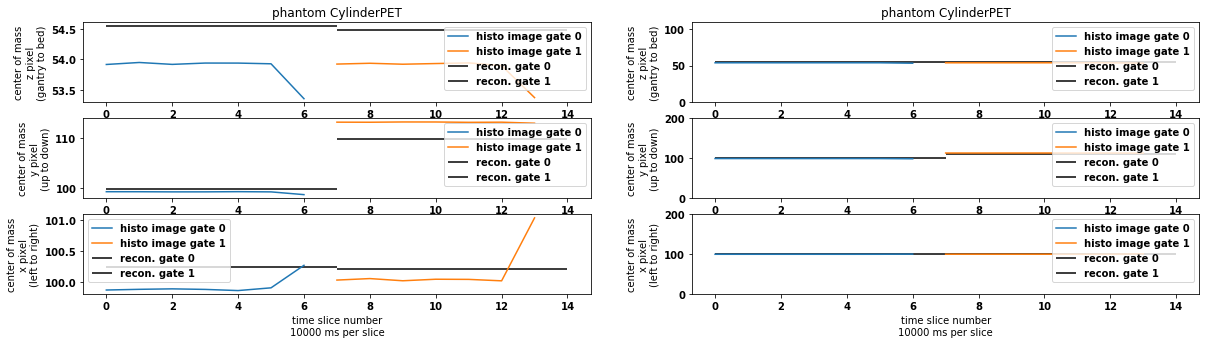

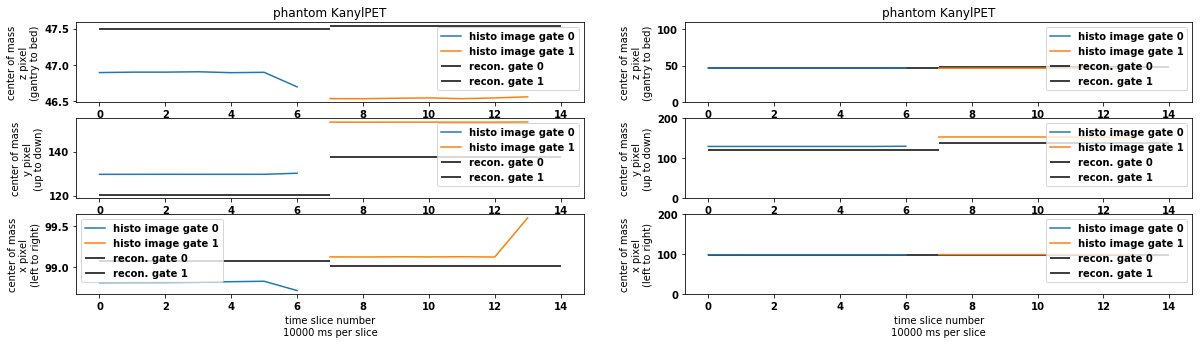

In [23]:
print(plot_com.__doc__)
print("not normalized")
plot_com(center_of_mass_trace_list)


normalized


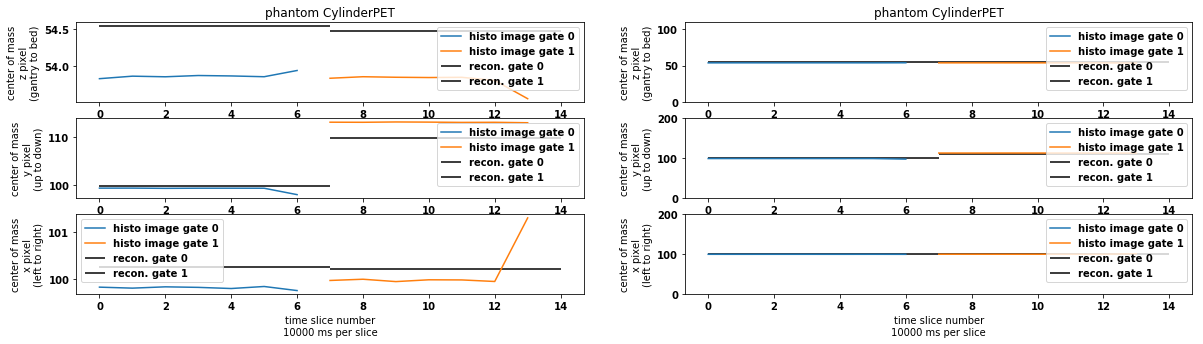

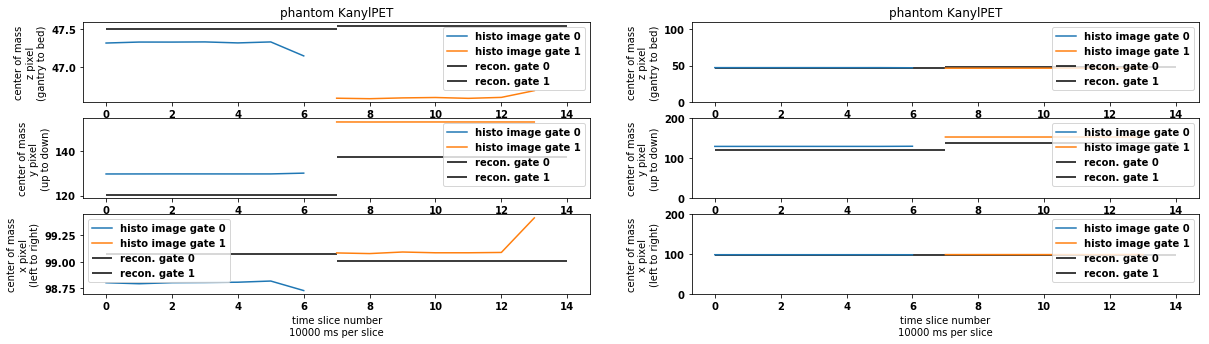

In [24]:
print("normalized")
plot_com(normalized_center_of_mass_trace_list)

comparison


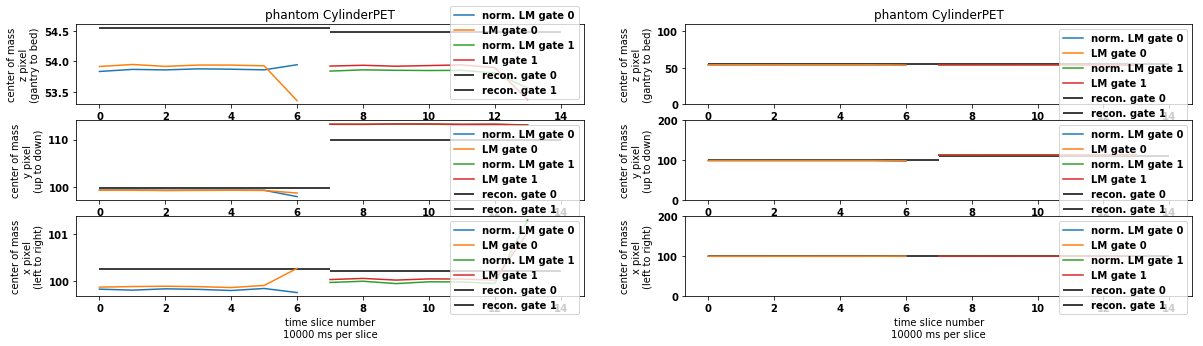

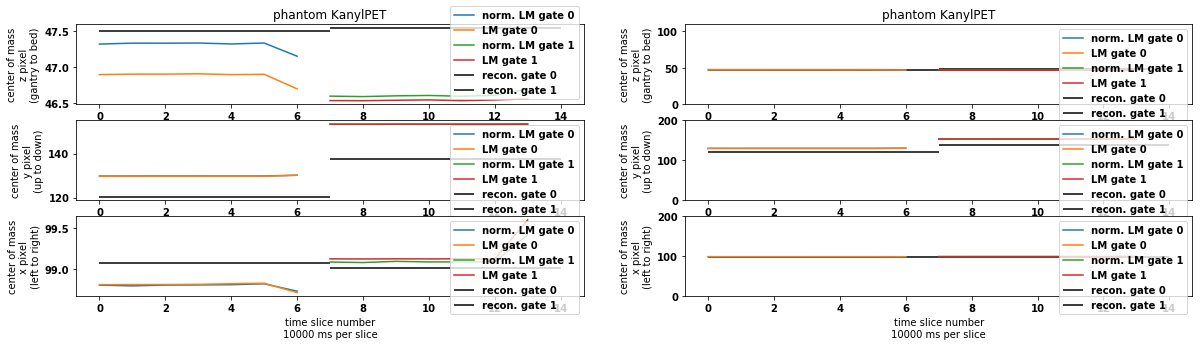

In [25]:
print("comparison")
plot_com(normalized_center_of_mass_trace_list, comparison_com_traces=center_of_mass_trace_list, legends=["norm. LM", "LM", "recon."])

In [27]:
#get a randoms sinogram
#first delays
#then optionally outside FOV
def get_LOR_delays(event_TOF_LOR_bins, prompt_in_event_boolarray):
    """ creates a LOR histogram with the randoms (delays).
    input: event_TOF_LOR_bins, prompt_in_event_boolarray
    return LOR_randoms_histogram """
    LOR_randoms_histogram = np.zeros(Utility.LOR_HISTOGRAM_SHAPE, dtype=np.int32)
    #exclude tof dimension, and add all the non-prompts (delays / randoms)
    np.add.at(LOR_randoms_histogram, tuple(event_TOF_LOR_bins[1:,prompt_in_event_boolarray == False]),1)
    
    return LOR_randoms_histogram

In [28]:
def get_randoms_outside_FOV(event_TOF_LOR_bins, prompt_in_event_boolarray, FOV_in_prompt_boolarray):
    """ creates a LOR histogram with the prompts outside FOV treated as randoms.
    Input: event_TOF_LOR_bins, prompt_in_event_boolarray, FOV_in_prompt_boolarray
    return LOR_randoms_histogram """
    LOR_randoms_histogram = np.zeros(Utility.LOR_HISTOGRAM_SHAPE, dtype=np.int32)
    outside_FOV_LOR_bins = event_TOF_LOR_bins[1:, prompt_in_event_boolarray][:,FOV_in_prompt_boolarray == False]
    np.add.at(LOR_randoms_histogram, tuple(outside_FOV_LOR_bins), 1)
    return LOR_randoms_histogram

In [29]:
def get_LOR_counts(LOR_bins):
    """ counts the occurence of each LOR in the given LOR bins and puts the counts into a LOR histogram.
    Input: LOR_bins
    return LOR_histogram """
    LOR_histogram = np.zeros(Utility.LOR_HISTOGRAM_SHAPE, dtype=np.int32)
    np.add.at(LOR_histogram, tuple(LOR_bins),1)
    return LOR_histogram

In [30]:
# get randoms
delays_LOR_histogram_list = []
#outside field of view, OFOV
OFOV_LOR_histogram_list = []
FOV_LOR_histogram_list = []
time_a = time.time()
for data_number, event_TOF_LOR_bins in enumerate(event_TOF_LOR_bins_list):
    prompt_b = prompt_boolarray_list[data_number]
    FOV_b = image_FOV_boolarray_list[data_number]
    lor_delays = get_LOR_delays(event_TOF_LOR_bins, prompt_in_event_boolarray=prompt_b)
    lor_OFOV_randoms = get_randoms_outside_FOV(event_TOF_LOR_bins, prompt_in_event_boolarray=prompt_b, FOV_in_prompt_boolarray=FOV_b)
    FOV_lor_bins = event_TOF_LOR_bins[1:, prompt_b][:,FOV_b]
    FOV_lor_counts = get_LOR_counts(FOV_lor_bins)
    
    delays_LOR_histogram_list.append(lor_delays)
    OFOV_LOR_histogram_list.append(lor_OFOV_randoms)
    FOV_LOR_histogram_list.append(FOV_lor_counts)
    
    time_b = time.time()
    print(time_str, time_b-time_a)
    
print("done")  

elapsed time [s] 4.707721710205078
elapsed time [s] 9.22871208190918
elapsed time [s] 16.9702410697937
elapsed time [s] 24.51206874847412
done


sum over mi axis


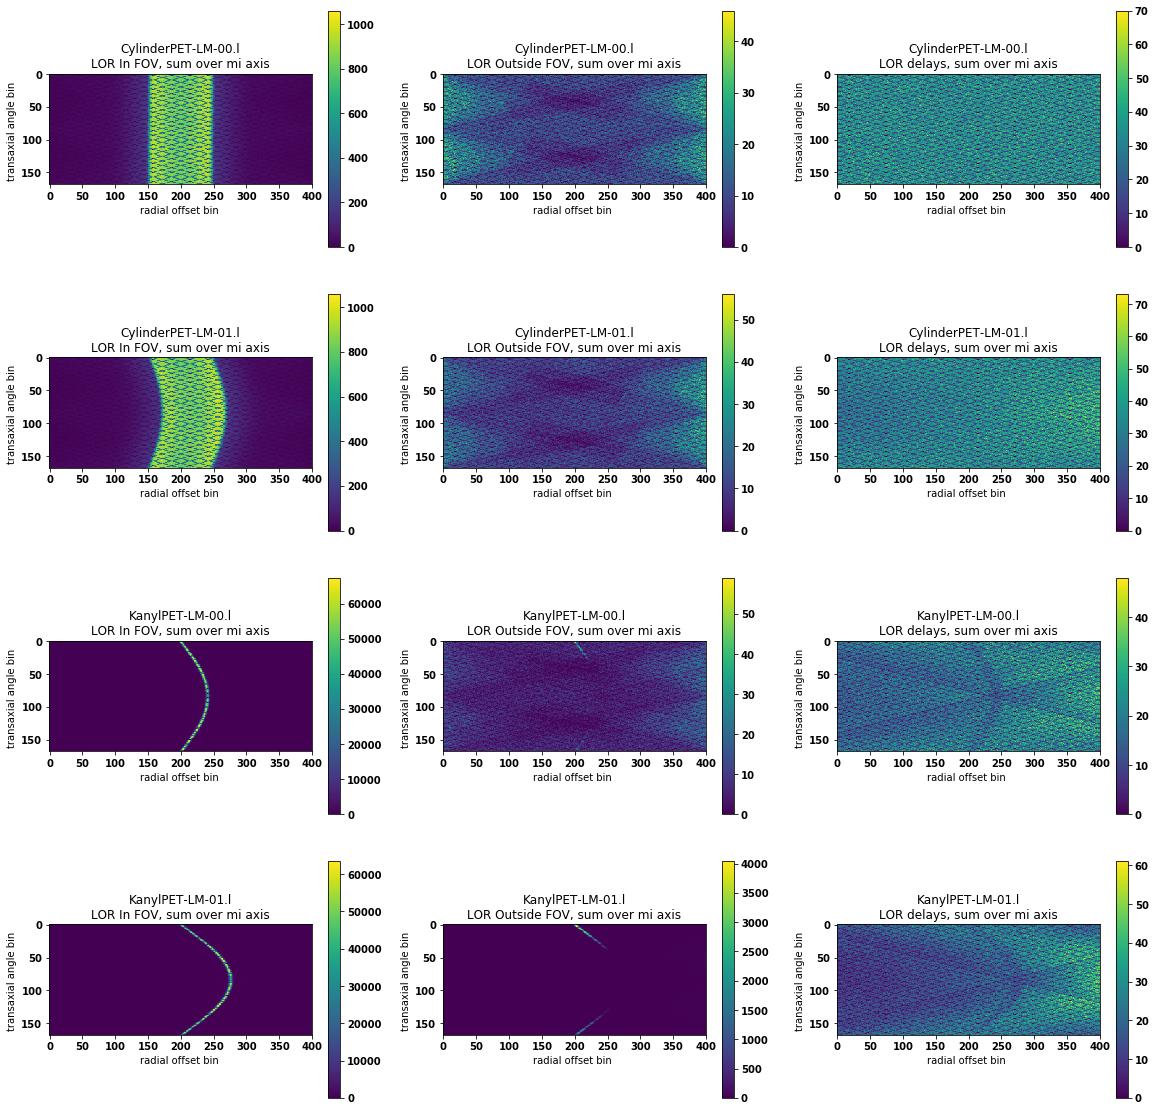

In [37]:
#plot correction sinograms
mi = 50
mi_str = "sum over mi axis"
print(mi_str)

random_corr_lists = [FOV_LOR_histogram_list, OFOV_LOR_histogram_list,delays_LOR_histogram_list]
random_corr_strings = ["In FOV", "Outside FOV", "delays"]
plt.figure(figsize=(20,20))
for data_number, LM_path in enumerate(LM_paths):
    dataset_str = LM_path.split('/')[-1]
    for corr_number,corr_sino_list in enumerate(random_corr_lists):
        plt.subplot(len(LM_paths),3, data_number*3+corr_number+1)
        plt.imshow(np.sum(corr_sino_list[data_number],axis=0))
        plt.title(dataset_str + "\nLOR " +random_corr_strings[corr_number] + ", " + mi_str)
        plt.ylabel(Utility.LOR_DIMENSION_TITLES[1])
        plt.xlabel(Utility.LOR_DIMENSION_TITLES[2])
        plt.colorbar()
plt.show()    

In [41]:
print(Utility.CenterOfMassMultiplication(delays_LOR_histogram_list[2]))
print(Utility.CenterOfMassMultiplication(OFOV_LOR_histogram_list[2]))

[297.78236739  83.60611102 216.83284298]
[297.42331624  83.30689493 220.14762944]


In [32]:
#get normalization sinograms that include random correction
#
randomcorr_norm3d_list = []
for data_number, norm3d in enumerate(norm3d_list):
    randoms = np.array(delays_LOR_histogram_list[data_number], dtype=np.float64)
    randoms += OFOV_LOR_histogram_list[data_number]
    FOV_LOR = FOV_LOR_histogram_list[data_number]
    nonzero_counts = FOV_LOR > 0
    
    #average randoms over all FOV LOR
    randoms[nonzero_counts] /= FOV_LOR[nonzero_counts]
    randomcorr_norm = norm3d - randoms
    #apply relu, no negative corrections
    randomcorr_norm = np.maximum(0, randomcorr_norm)
    randomcorr_norm3d_list.append(randomcorr_norm)

michelogram bin 47


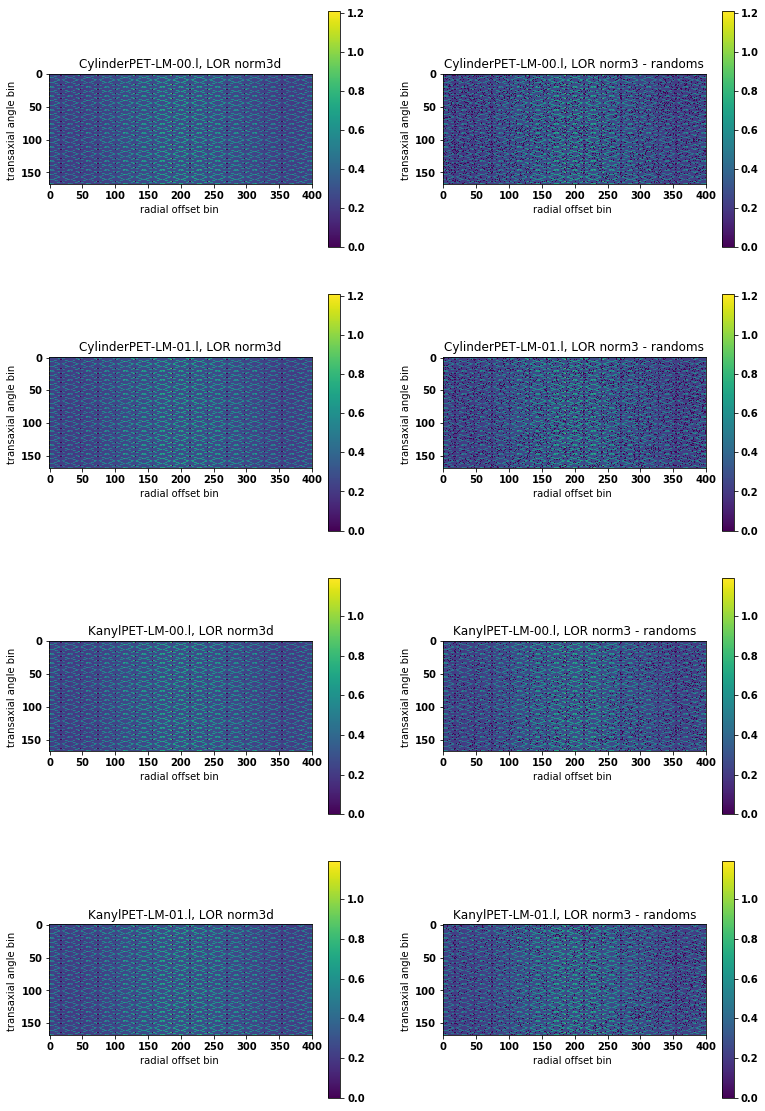

In [33]:
#plot normalization sinograms
#plot correction sinograms
mi = 47
print("michelogram bin", 47)
sino_lists = [norm3d_list, randomcorr_norm3d_list]
sino_strings = ["norm3d", "norm3 - randoms", ]
plt.figure(figsize=(20,20))
for data_number, LM_path in enumerate(LM_paths):
    dataset_str = LM_path.split('/')[-1]
    for sino_number,sino_list in enumerate(sino_lists):
        plt.subplot(len(LM_paths),3, data_number*3+sino_number+1)
        plt.imshow(sino_list[data_number][mi])
        plt.title(dataset_str + ", LOR " +sino_strings[sino_number])
        plt.ylabel(Utility.LOR_DIMENSION_TITLES[1])
        plt.xlabel(Utility.LOR_DIMENSION_TITLES[2])
        plt.colorbar()
plt.show()    

In [34]:
#test center of mass with random correction
print(get_center_of_mass_trace.__doc__)
random_norm_center_of_mass_trace_list = []
time_a = time.time()
for data_number, path in enumerate(LM_paths):
    com_trace = get_center_of_mass_trace(FOV_image_bins_list[data_number], 
                                         timeslices_in_FOV_list[data_number],
                                         FOV_LOR_bins_list[data_number],
                                        randomcorr_norm3d_list[data_number])
    random_norm_center_of_mass_trace_list.append(com_trace)
    time_b = time.time()
    print(time_str, time_b-time_a)
print("done")

 get_center_of_mass_trace: splits image bins into timeslices and calculates the center of mass (mean). 
    If sinogram bins and normalization is provided, the center of mass is normalized. 
    Input: image_bins, split_at_indices,sinogram_bins=None, norm_sinogram3d=None, verbose=False
    return com_trace
    FOV_image_bins is assumed to be shaped (3,_), and the return is shaped (3,_)
elapsed time [s] 1.2963840961456299
elapsed time [s] 2.6598544120788574
elapsed time [s] 5.514576435089111
elapsed time [s] 7.9449567794799805
done


 plot_com: plots the center of mass traces in z y x along with the reference (constant lines)
    gates are plotted together, with adjacent first-last timeslices.
    input: com_traces,
    comparison_com_traces=None, 
    com_references=recon_com,
    gates_per_phantom=[2,2],
    legends=["histo image", "recon."],
    data_paths=LM_paths


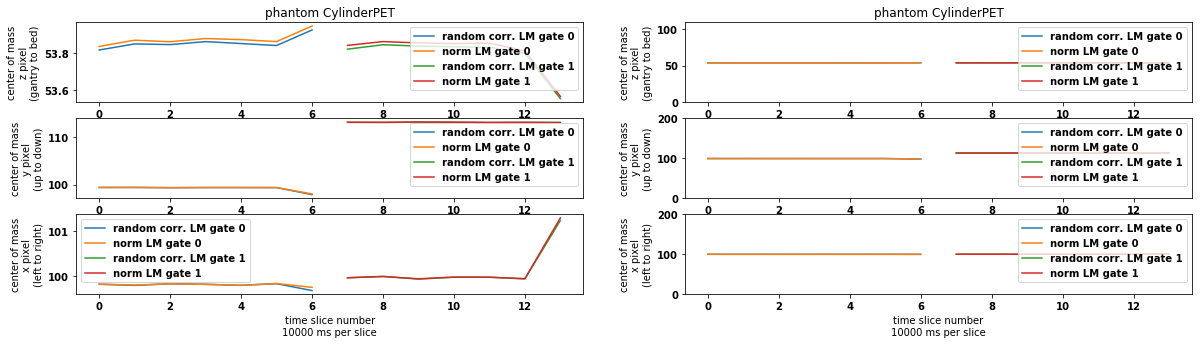

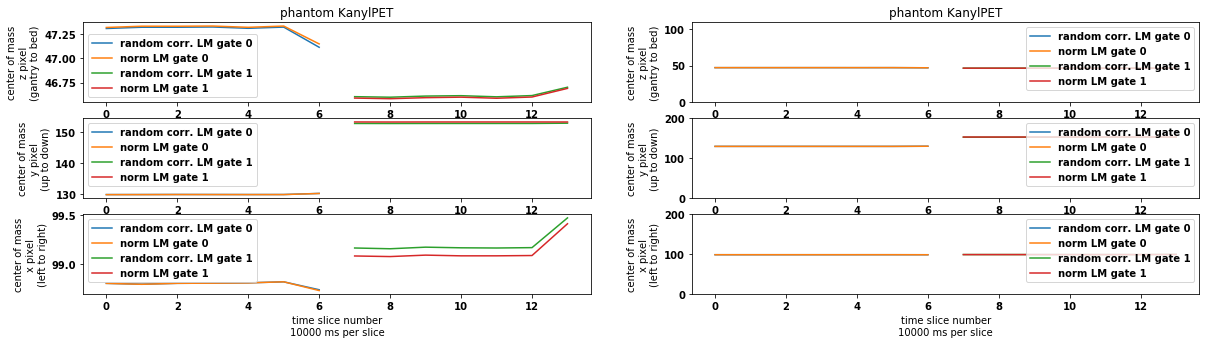

In [35]:
print(plot_com.__doc__)
plot_com(com_traces=random_norm_center_of_mass_trace_list, 
         comparison_com_traces=normalized_center_of_mass_trace_list,
         com_references=None,
        legends=["random corr. LM", "norm LM", "recon."])

In [42]:
A = np.zeros((5,17,12))
print(len(A))

5
